In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import seaborn

pd.set_option('display.max_rows', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import re
from scipy.stats import entropy

df = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",")
df = df.set_index("palabra")

fnorm_vars = [c for c in df.columns if re.match(r'fnorm_.*', c)]
cant_palabras = [c for c in df.columns if re.match(r'.*Palabras$', c)]
cant_personas = [c for c in df.columns if re.match(r'.*Personas$', c)]

In [60]:
from iv_helpers import simulated_shuffled_entropy_multinomial

fn = lambda ws: simulated_shuffled_entropy_multinomial(ws, len(cant_palabras))

df["entropy_palabras"] = df[cant_palabras].apply(entropy, axis=1, raw=True)
df["entropy_personas"] = df[cant_personas].apply(entropy, axis=1, raw=True)
df["shuffled_entropy_personas"] = df.cantUsuariosTotal.apply(fn)
df["shuffled_entropy_palabras"] = df.cantPalabra.apply(fn)

In [61]:
print df.cantUsuariosTotal.min()
print df.cantPalabra.min()

6
41


In [62]:
cantPalabrasTotales = sum(df.cantPalabra)
df['fnormArgentina'] = df['cantPalabra']/cantPalabrasTotales

In [63]:
df.fnormArgentina


palabra
a                    2.632803e-02
aa                   2.267000e-05
aaa                  8.730575e-05
aaaca                2.387432e-07
aaadentro            3.342405e-07
aaag                 3.979054e-07
aaaggg               3.979054e-07
aaah                 4.978592e-05
aaahh                3.597065e-06
aaahhh               1.037737e-05
aaahi                2.546594e-07
aaahora              2.493540e-07
aaai                 1.522651e-06
aaaii                2.758811e-07
aaaiii               5.889000e-07
aaaj                 6.525648e-07
aaajaja              2.705757e-07
aaajajaja            4.934027e-07
aaajajajaja          4.509594e-07
aaajajajajaja        5.040135e-07
aaajajajajajaja      2.864919e-07
aaajajajajajajaja    2.334378e-07
aaal                 1.596927e-06
aaala                8.541702e-07
aaalgo               9.761946e-07
aaalguien            3.501567e-07
aaall                2.334378e-07
aaalta               1.013332e-06
aaalto               1.050470e-06
aaam  

In [64]:
df.entropy_personas.describe()

count    75878.000000
mean         2.842564
std          0.409441
min          0.000000
25%          2.796571
50%          2.959232
75%          3.059217
max          3.135044
Name: entropy_personas, dtype: float64

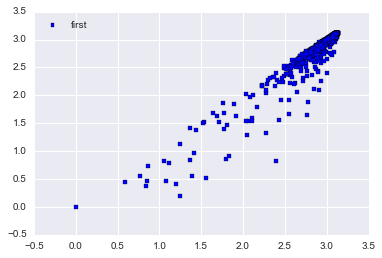

In [65]:
import matplotlib.pyplot as plt

x = df.entropy_personas[:1000]
y = df.entropy_palabras[:1000]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', marker="s", label='first')
plt.legend(loc='upper left');
plt.show()

In [66]:
df.cantPalabra.describe()

count    7.587800e+04
mean     2.484080e+03
std      6.000610e+04
min      4.100000e+01
25%      6.900000e+01
50%      1.390000e+02
75%      4.300000e+02
max      7.509160e+06
Name: cantPalabra, dtype: float64

Si le aplico el logaritmo a la cantidad de la Palabra, ya no tiene tanta importancia la cantidad y por lo tanto, las palabras palabras comunes como **que**, **y**,**el**,etc. dejan de tener tanto valor de información

In [191]:
import math
# df['normCantPalabras']=(df.cantPalabra.apply(math.log,args=(2,))-df.cantPalabra.apply(math.log,args=(2,)).min())/(df.cantPalabra.apply(math.log,args=(2,)).max()-df.cantPalabra.apply(math.log,args=(2,)).min())
# df['normCantPersonas']=(df.cantUsuariosTotal.apply(math.log,args=(2,))-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())/(df.cantUsuariosTotal.apply(math.log,args=(2,)).max()-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())
df['normCantPalabras']=(df.cantPalabra-df.cantPalabra.mean())/(df.cantPalabra.std())
df['normCantPersonas']=(df.cantUsuariosTotal-df.cantUsuariosTotal.mean())/(df.cantUsuariosTotal.std())

In [70]:
from iv_helpers import lugares
places = lugares()
print len(places)
df['esLugar'] = np.where(df.index.str.decode(encoding='utf-8').isin(places),'lugar','ok')

3006


### Normalizo el valor de la cantidad de ocurrencias de una palabra y de usuarios que la utilizan.

$$ norm_{CantPalabras} = \frac{log_2(\#Palabra)- min(log_2(\#Palabra))}{max(log_2(\#Palabra)) - min(log_2(\#Palabra))}$$

$$norm_{CantPersonas} = \frac{log_2(\#Usuarios)- min(log_2(\#Usuarios))}{max(log_2(\#Usuarios)) - min(log_2(\#Usuarios))}$$

De esta forma, estos dos valores están en el rango 0-1

La métrica llamada $InformationValue_{PersonasPalabras}$

$$InformationValue_{PersonasPalabras} =  norm_{CantPalabras} * norm_{CantPersonas} * (\widehat{H}_{personas} - H_{personas}) * (\widehat{H}_{palabras} - H_{palabras})$$

donde $\widehat{H}$ es la entropía con las cantidades distribuidas uniformemente y H es la entropía común

$$ InformationValue_{PersonasPalabras} =  norm_{CantPalabras} * norm_{CantPersonas} * (\widehat{H}_{personas} - H_{personas}) * (\widehat{H}_{palabras} - H_{palabras}) $$

In [423]:
import math

df["information_value_palabras"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas)
# df["information_value_personas_palabras"] = (df.cantUsuariosTotal.apply(math.log,args=(2,))) * (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
# df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
# df["information_value_personas_palabras"] = df.cantPalabra * df.cantUsuariosTotal * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)

#df["information_value_FnormMax"] = (df.FnormMax) * (df.shuffled_entropy - df.entropy)

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
df['rankPalabras'] = df['information_value_palabras'].rank(ascending=False).astype('int64')
df['rankPersonas'] = df['information_value_personas'].rank(ascending=False).astype('int64')
df['rankPalabras_Personas'] = df['information_value_personas_palabras'].rank(ascending=False).astype('int64')


palabrasPersonas = [c for c in df.columns if re.match(r'.*PalabrasPersonas', c)]
# df = df.set_index('palabra')
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
df.iloc[:1000][['cantPalabra','esLugar','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','normCantPersonas','normCantPalabras','shuffled_entropy_personas','entropy_personas']]

,cantPalabra,esLugar,cantUsuariosTotal,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas,normCantPersonas,normCantPalabras,shuffled_entropy_personas,entropy_personas
palabra,,,,,,,,,,,
rioja,22489,lugar,1573,larioja,2,469,1,0.609303,0.333381,3.129665,2.054848
jujuy,17090,lugar,1905,jujuy,14,1350,2,0.807653,0.243407,3.127873,2.417933
teres,13928,ok,2787,chaco,682,1102,3,1.334594,0.190713,3.132110,2.305106
ushuaia,14966,lugar,1006,tierradelfuego,1,52,4,0.270555,0.208011,3.125030,1.453279
corrientes,12827,lugar,2229,corrientes,147,1634,5,1.001223,0.172364,3.130787,2.493017
comodoro,10642,lugar,1346,chubut,13,374,6,0.473685,0.135952,3.126898,1.910122
catamarca,9957,lugar,1469,catamarca,54,738,7,0.547170,0.124536,3.128834,2.102812
wsp,20464,ok,3540,catamarca,2685,3101,8,1.784466,0.299635,3.132962,2.772159
salta,25975,lugar,5554,salta,608,14733,9,2.987708,0.391476,3.134098,3.053430


## Hago un dataframe con las palabras candidatas, cada una con las cantidades de ocurrencias por provincia de forma ordenada

In [424]:
cant = [c for c in df.columns if re.match(r'.*Palabras$', c) and (not re.match(r'.*norm', c) ) and (not re.match(r'.*rank', c) )]

dfCant = df[cant]
# Palabras candidatas según la AAL
palabras = ["quedarla","mitaí","angá","yungas","mensajeras","yarco","yarca",
"malpegar","malpegue","malpegada","tareferos","hartante","guaracha","esar","ñeri",
"piadina","chombi","achilata","pollerear","juntadera","pachata","chamigo","chamiga",
"chaque","pichar","tortita","guaso","guasa","comparsero","comparsera","sina","lape","veme","porronear",
"fajita","jia","jía","asada","asar","manso","cora","cumpa","pingo","charro","pinchila","oyo","ura","yuto",
"yagua","cantobar","cha","bombolo","bombola","yafu","jal","gatera","atina",
"guampudo","guampuda","mamila","chui","tico"]
# top_n = 23
# dfCant = dfCant.loc[palabras].dropna()
# dfLargestNum = pd.DataFrame({col: dfCant.T[col].nlargest(top_n).tolist() 
#                   for n, col in enumerate(dfCant.T)}).T
# dfLargestNum

In [459]:
dfC = df.sort_values(by="information_value_palabras", ascending=False, inplace=False)

# dfC = df[cant].sort
dfC.cantUsuariosTotal

palabra
ushuaia                          1006
rioja                            1573
oberá                             378
chivilcoy                         469
logroño                           132
breñas                            170
viedma                            666
tdf                               300
bragado                           294
riojanos                          336
ush                               465
fueguinos                         145
comodoro                         1346
jujuy                            1905
gallegos                         1258
calamuchita                       128
obera                             410
unju                               47
merlo                             994
blv                               174
choele                            229
cldo                              224
rionegrinas                        29
concordia                         798
sciurano                          124
ágora                              17
char

In [444]:
sort_xs = dfC.apply(np.sort, axis=1)
sort_index = dfC.apply(np.argsort, axis=1)
sort_xs.columns = range(23)
sort_index.columns = range(23)
cols = sort_xs.columns.tolist()
cols = cols[::-1]
sort_xs = sort_xs[cols]
sort_index = sort_index[cols]
sort_xs.columns= range(23)
sort_index.columns = range(23)

In [446]:
percent = sort_xs.div(sort_xs.sum(axis=1), axis='index')

In [447]:
# percent.drop('total', axis=1, inplace=True)
percent

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
palabra,,,,,,,,,,,,,,,,,,,,,
ushuaia,0.962649,0.006749,0.004410,0.003140,0.002339,0.002205,0.002071,0.001938,0.001871,0.001670,...,0.001270,0.000935,0.000802,0.000735,0.000535,0.000535,0.000535,0.000535,0.000535,0.000267
rioja,0.914136,0.030948,0.007426,0.006714,0.005603,0.004758,0.004002,0.003957,0.003824,0.002890,...,0.001645,0.001556,0.001378,0.001334,0.001023,0.000845,0.000711,0.000667,0.000667,0.000356
oberá,0.981953,0.007867,0.003702,0.001157,0.000925,0.000925,0.000694,0.000463,0.000463,0.000463,...,0.000231,0.000231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chivilcoy,0.979872,0.003682,0.003436,0.002209,0.001718,0.001227,0.000982,0.000982,0.000736,0.000736,...,0.000736,0.000491,0.000245,0.000245,0.000245,0.000245,0.000000,0.000000,0.000000,0.000000
logroño,0.999228,0.000386,0.000386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
breñas,0.994981,0.001931,0.001931,0.000386,0.000386,0.000386,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
viedma,0.938335,0.017011,0.013062,0.005923,0.005164,0.004253,0.002430,0.002278,0.001519,0.001367,...,0.000911,0.000759,0.000759,0.000759,0.000608,0.000456,0.000304,0.000304,0.000304,0.000152
tdf,0.974963,0.009573,0.003314,0.002209,0.001473,0.001473,0.001105,0.001105,0.000736,0.000736,...,0.000368,0.000368,0.000368,0.000368,0.000368,0.000368,0.000000,0.000000,0.000000,0.000000
bragado,0.970766,0.006417,0.005348,0.003922,0.003922,0.002139,0.002139,0.001783,0.001426,0.000713,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


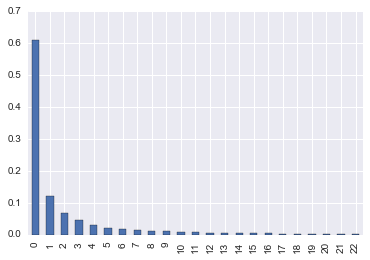

In [448]:
percent.loc[palabras].mean().T.plot(kind='bar')

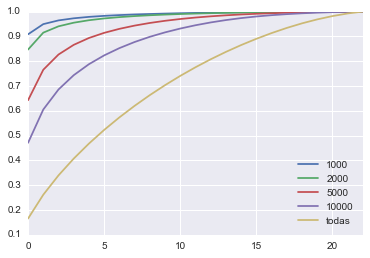

In [449]:
dfAcum = pd.DataFrame()
dfAcum['1000'] = percent.iloc[:1000].cumsum(axis=1).mean()
dfAcum['2000'] = percent.iloc[:2000].cumsum(axis=1).mean()
dfAcum['5000'] = percent.iloc[:5000].cumsum(axis=1).mean()
dfAcum['10000'] = percent.iloc[:10000].cumsum(axis=1).mean()
dfAcum['todas'] = percent.cumsum(axis=1).mean()
dfAcum.plot()

# Vemos como se distribuye la suma acumulada de proporciones de las palabras

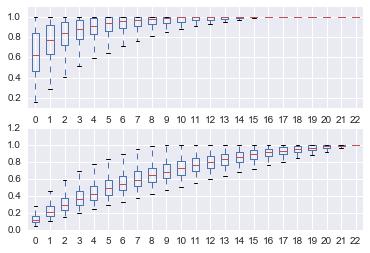

In [450]:
fig, axes = plt.subplots(nrows=2, ncols=1)
percent.iloc[:5000].cumsum(axis=1).boxplot(return_type='axes',ax=axes[0])
percent.cumsum(axis=1).boxplot(return_type='axes',ax=axes[1])


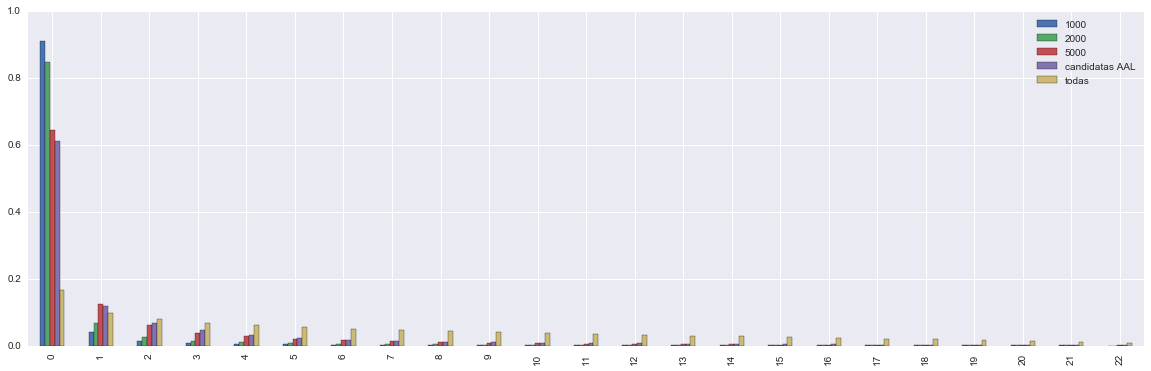

In [451]:
dfp = pd.DataFrame()
dfp['1000'] = percent.iloc[0:1000].mean().T
dfp['2000'] = percent.iloc[0:2000].mean().T
dfp['5000'] = percent.iloc[0:5000].mean().T
dfp['candidatas AAL'] = percent.loc[palabras].mean().T
dfp['todas'] = percent.mean().T
dfp.plot(kind='bar',figsize=[20,6])

In [73]:
dfCant = df[cant]

## Hago un dataframe con las palabras candidatas, cada una con las provincias ordenadas según cuantas veces ocurre una palabra en cada una de ellas

In [341]:
df.sort_values(by='information_value_personas_palabras',ascending=False,inplace=True)
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','entropy_palabras','entropy_personas']].to_csv('resumido.csv')

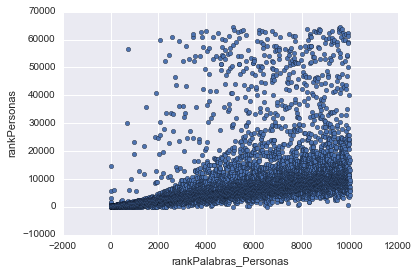

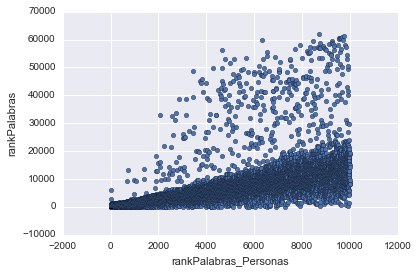

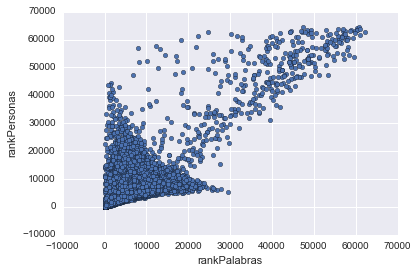

In [342]:
df.iloc[:10000].plot.scatter(x='rankPalabras_Personas',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='rankPalabras_Personas',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='rankPalabras',y='rankPersonas')

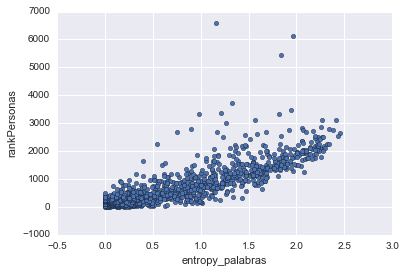

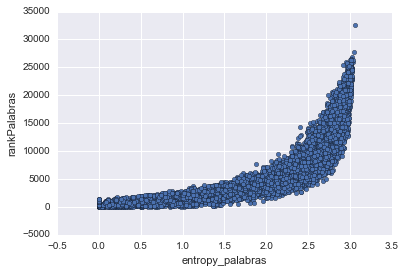

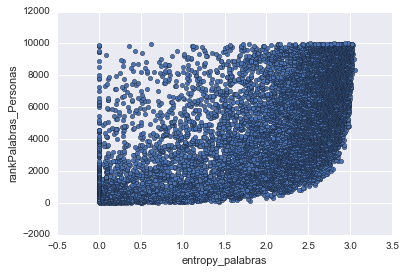

In [77]:
df.iloc[:1000].plot.scatter(x='entropy_palabras',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras_Personas')

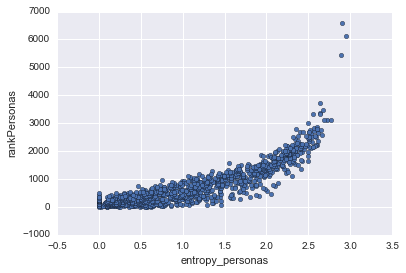

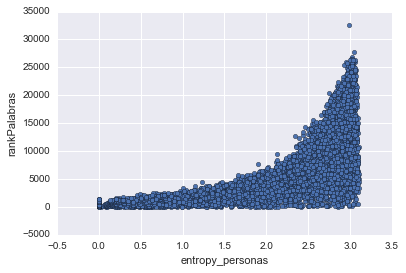

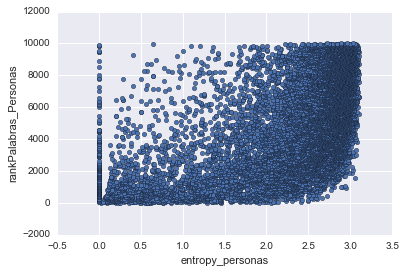

In [78]:
df.iloc[:1000].plot.scatter(x='entropy_personas',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='entropy_personas',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='entropy_personas',y='rankPalabras_Personas')

## Guardo los listados (resumidos, y extendidos) ordenados en base a las dos médidas de información

In [ ]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_palabras_resumida.csv')
df.to_csv('ivalue_entropia_palabras.csv')

df.sort_values(by="information_value_personas", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_personas_resumida.csv')
df.to_csv('ivalue_entropia_personas.csv')

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed = resumed[['cantPalabra','esLugar','cantUsuariosTotal','fnormArgentina','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
resumed.to_csv('ivalue_entropia_personas_palabras_resumida.csv')


df.to_csv('ivalue_entropia_personas_palabras.csv')

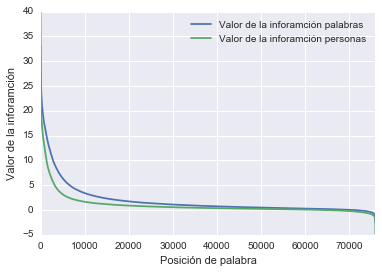

In [314]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
df2 = df.reset_index()
ax = df2.information_value_palabras.plot.line()
df.sort_values(by="information_value_personas", ascending=False, inplace=True)
df2 = df.reset_index()

df2.information_value_personas.plot.line()
ax.legend([u'Valor de la inforamción palabras',u'Valor de la inforamción personas'])

ax.set_xlabel(u'Posición de palabra')
ax.set_ylabel(u'Valor de la inforamción')


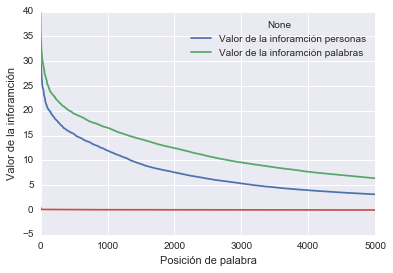

In [433]:
df2 = df.sort_values(by="information_value_personas", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas.plot(xlim=[0,5000])
df2 = df.sort_values(by="information_value_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_palabras.plot(xlim=[0,5000])
ax2.legend([u'Valor de la inforamción personas',u'Valor de la inforamción palabras'])

df2 = df.sort_values(by="information_value_personas_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas_palabras.plot(xlim=[0,5000])


ax2.set_xlabel(u'Posición de palabra')
ax2.set_ylabel(u'Valor de la inforamción')


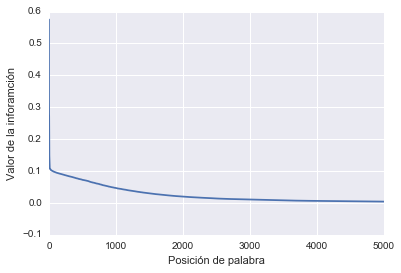

In [434]:
df2 = df.sort_values(by="information_value_personas_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas_palabras.plot(xlim=[0,5000])


ax2.set_xlabel(u'Posición de palabra')
ax2.set_ylabel(u'Valor de la inforamción')

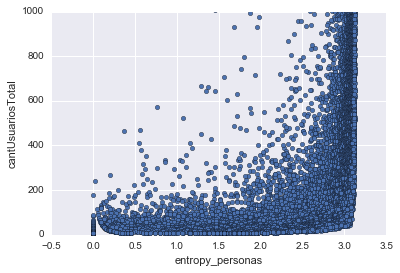

In [90]:
df.plot.scatter(x="entropy_personas", y="cantUsuariosTotal", ylim=[0, 1000])

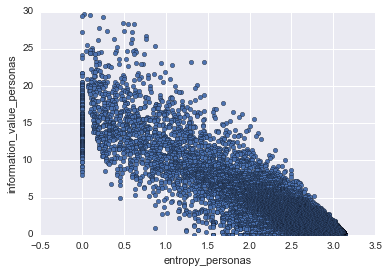

In [91]:
df.plot.scatter(x="entropy_personas", y="information_value_personas", ylim=[0, 30])

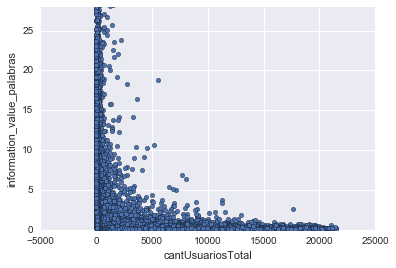

In [92]:
df.plot.scatter(x="cantUsuariosTotal", y="information_value_palabras", ylim=[0, 28])

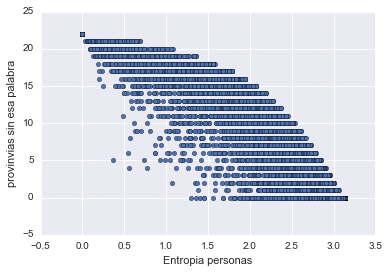

In [93]:
plt.figure(1)
df.plot.scatter(x="entropy_personas", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia personas")
plt.ylabel("provinvias sin esa palabra")


plt.show()


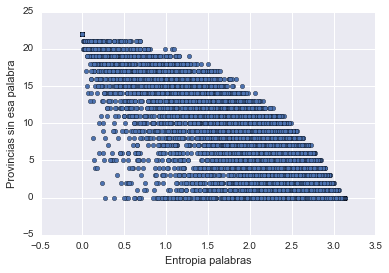

In [96]:
plt.figure(2)
df.plot.scatter(x="entropy_palabras", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia palabras")
plt.ylabel("Provincias sin esa palabra")

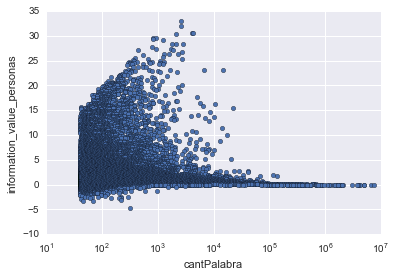

In [95]:
df.plot.scatter(y="information_value_personas", x="cantPalabra", logx=True)

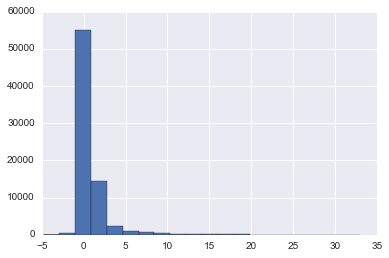

In [97]:
df.information_value_personas.hist(bins=20)

In [343]:
resumed[df.information_value_personas < 0].iloc[:100]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,FnormMax,FnormMin,cantPalabra,cantUsuariosTotal,entropy_palabras,entropy_personas,esLugar,fnormArgentina,information_value_palabras,information_value_personas,...,normCantPalabras,normCantPersonas,provinciaFnormMax,provinciaFnormMin,provinciaSinEsaPalabra,rankPalabras,rankPalabras_Personas,rankPersonas,shuffled_entropy_palabras,shuffled_entropy_personas
palabra,,,,,,,,,,,,,,,,,,,,,
pregunteee,0.543794,0.111157,52,51,3.031230,3.031215,ok,2.758811e-07,-1.365775,-1.664476,...,-0.040531,-0.299999,santiago,lapampa,1,75855,11804,75805,2.791639,2.739224
extravío,0.562762,0.099246,43,37,2.925002,2.945688,ok,2.281324e-07,-1.006757,-1.933414,...,-0.040681,-0.308363,chubut,cordoba,2,75766,11957,75845,2.739468,2.589381
patient,0.477453,0.105675,43,39,2.991090,2.983484,ok,2.281324e-07,-1.098993,-1.698292,...,-0.040681,-0.307168,sanjuan,entrerios,1,75806,12271,75813,2.788558,2.670507
volvereee,0.840085,0.099246,43,41,2.923392,2.956945,ok,2.281324e-07,-1.185357,-1.471372,...,-0.040681,-0.305973,jujuy,cordoba,1,75827,12746,75740,2.704944,2.685787
jaajjajajajajaja,0.490117,0.100082,43,42,2.918709,2.928675,ok,2.281324e-07,-1.422666,-1.207519,...,-0.040681,-0.305376,catamarca,rionegro,3,75864,12846,75570,2.656528,2.706143
vagabundeando,0.596816,0.099246,45,40,2.965194,2.991146,ok,2.387432e-07,-1.320459,-1.248530,...,-0.040647,-0.306570,sanjuan,cordoba,1,75845,13278,75598,2.724755,2.763804
juanete,0.500409,0.106356,46,38,2.926430,2.925842,ok,2.440486e-07,-1.455212,-1.132987,...,-0.040631,-0.307765,rionegro,mendoza,2,75866,13352,75503,2.662975,2.720723
platas,0.815691,0.108242,42,39,2.903759,2.956650,ok,2.228270e-07,-1.467500,-1.030723,...,-0.040697,-0.307168,santiago,tucuman,1,75867,13612,75358,2.631612,2.765504
desencanto,0.556763,0.100082,53,50,3.011863,3.006992,ok,2.811865e-07,-1.329774,-1.255356,...,-0.040514,-0.300596,formosa,rionegro,1,75848,13958,75605,2.779706,2.787827


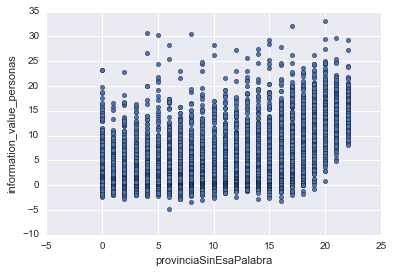

In [344]:
df.plot.scatter(x="provinciaSinEsaPalabra", y="information_value_personas")

In [ ]:
df.plot.scatter(x="provinciaSinEsaPalabra", y="entropy_personas")

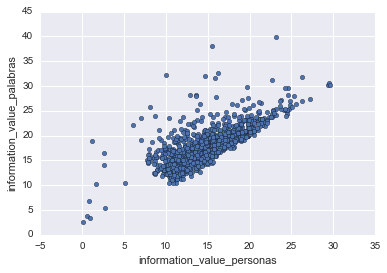

In [377]:
ax = df.iloc[:1000].plot(kind='scatter',x='information_value_personas',y='information_value_palabras')
plt.show()

In [367]:
df[df.provinciaSinEsaPalabra > 17].iloc[:5000][["cantPalabra", "provinciaSinEsaPalabra"]]

,cantPalabra,provinciaSinEsaPalabra
palabra,,
nomeee,42,22
lechman,117,22
simalu,58,22
choeleee,83,22
gaunas,113,22
aijj,76,22
entoe,90,22
chivilvoy,94,22
noxxx,109,22


In [369]:
(df.shuffled_entropy_personas - df.entropy_personas).describe()

count    75878.000000
mean         0.141988
std          0.336594
min         -0.594126
25%          0.013390
50%          0.050502
75%          0.135546
max          3.092068
dtype: float64

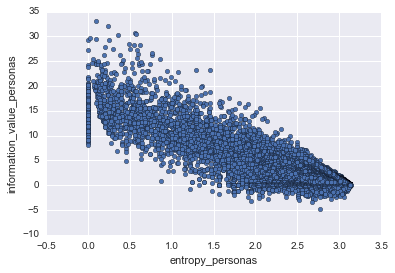

In [370]:
df.plot.scatter(x="entropy_personas", y="information_value_personas")

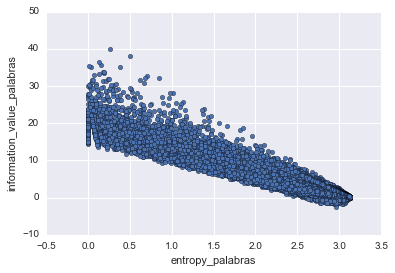

In [371]:
df.plot.scatter(x="entropy_palabras", y="information_value_palabras")

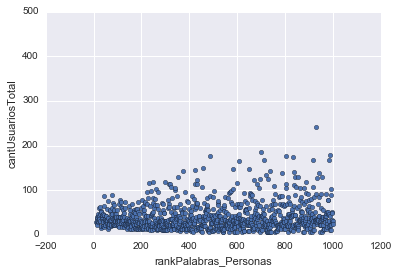

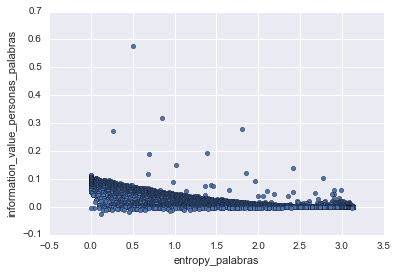

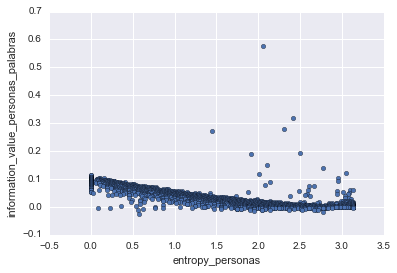

In [372]:
df.iloc[:1000].plot.scatter(x="rankPalabras_Personas", y="cantUsuariosTotal",ylim=[0,500])

df.plot.scatter(x="entropy_palabras", y="information_value_personas_palabras")
df.plot.scatter(x="entropy_personas", y="information_value_personas_palabras")


In [375]:
df.iloc[:5000][df.iloc[:5000].esLugar == 'lugar'].count()

buenosairesPalabras                    514
catamarcaPalabras                      514
chacoPalabras                          514
chubutPalabras                         514
cordobaPalabras                        514
corrientesPalabras                     514
entreriosPalabras                      514
formosaPalabras                        514
jujuyPalabras                          514
lapampaPalabras                        514
lariojaPalabras                        514
mendozaPalabras                        514
misionesPalabras                       514
neuquenPalabras                        514
rionegroPalabras                       514
saltaPalabras                          514
sanjuanPalabras                        514
sanluisPalabras                        514
santacruzPalabras                      514
santafePalabras                        514
santiagoPalabras                       514
tierradelfuegoPalabras                 514
tucumanPalabras                        514
cantPalabra